# wave2web data

In [1]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import pandas as pd 

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from neuralhydrology.utils.config import Config

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from scripts.read_nh_results import (
    read_multi_experiment_results,
    calculate_member_errors
)

# Load forecasts and evaluate

In [3]:
data_dir = Path("/datadrive/data")
run_dir = data_dir / "wave2web_data/runs/wave2web"
run_paths = [d for d in run_dir.iterdir() if d.is_dir()]
run_paths

[PosixPath('/datadrive/data/wave2web_data/runs/wave2web/wave2web_Y1_2507_203708'),
 PosixPath('/datadrive/data/wave2web_data/runs/wave2web/wave2web_Y60_2507_203710'),
 PosixPath('/datadrive/data/wave2web_data/runs/wave2web/wave2web_Y90_2507_203732'),
 PosixPath('/datadrive/data/wave2web_data/runs/wave2web/wave2web_Y30_2507_203735')]

In [4]:
all_preds = []
all_errors = {}
for run_ in run_paths:
    VAR = run_.name.split("_")[-3]
    res_fp = get_test_filepath(run_, epoch=30)
    preds = get_all_station_ds(res_fp)
    preds["station_id"] = preds["station_id"].astype(int)
    obs_var = [v for v in preds.data_vars if "_obs"in v][0]
    sim_var = [v for v in preds.data_vars if "_sim"in v][0]
    all_preds.append(preds)
    errors = calculate_all_error_metrics(preds, basin_coord="station_id", obs_var=obs_var, sim_var=sim_var)
    errors["station_id"] = errors["station_id"].astype(int)
    all_errors[VAR] = errors

Calculating Errors: 100%|██████████| 4/4 [00:00<00:00, 17.49it/s, 3]


In [5]:
[p.data_vars for p in all_preds]

[Data variables:
     Y1_obs   (station_id, date) float64 1.66 1.67 1.68 1.69 ... nan nan nan nan
     Y1_sim   (station_id, date) float64 1.511 1.493 1.543 1.549 ... nan nan nan,
 Data variables:
     Y60_obs  (station_id, date) float64 1.92 1.92 1.92 1.92 ... nan nan nan nan
     Y60_sim  (station_id, date) float64 1.633 1.632 1.679 1.684 ... nan nan nan,
 Data variables:
     Y90_obs  (station_id, date) float64 1.61 1.59 1.57 1.55 ... nan nan nan nan
     Y90_sim  (station_id, date) float64 1.545 1.563 1.602 1.609 ... nan nan nan,
 Data variables:
     Y30_obs  (station_id, date) float64 1.86 2.67 2.67 2.68 ... nan nan nan nan
     Y30_sim  (station_id, date) float64 1.726 1.732 1.789 1.796 ... nan nan nan]

In [6]:
all_preds = xr.merge(all_preds)

# How did the forecast perform?

In [7]:
# CONVERT METRICS TO DATAFRAME (PLOTTING EASE)
all_metrics = []
targets = sorted([target for target in all_errors.keys()])

for m in all_errors[targets[0]].data_vars:
    metrics = []
    for ix, t in enumerate(targets):
        err = all_errors[t]
        _err_df = err[m].to_dataframe().stack().reset_index().rename({"level_1": "metric", 0: t, "station_id": "reservoir"}, axis=1).set_index(["reservoir", "metric"])
        metrics.append(_err_df)

    metrics = pd.concat(metrics, axis=1)
    metrics.reset_index("metric")
    all_metrics.append(metrics)
    
all_metrics = pd.concat(all_metrics).reset_index()
all_metrics = all_metrics.set_index(["reservoir", "metric"]).stack().reset_index().rename({"level_2": "forecast", 0: "value"}, axis=1)
all_metrics.head()

,reservoir,metric,forecast,value
0,0,Alpha-NSE,Y1,1.032659
1,0,Alpha-NSE,Y30,1.069245
2,0,Alpha-NSE,Y60,1.096496
3,0,Alpha-NSE,Y90,1.193185
4,1,Alpha-NSE,Y1,1.006885


In [8]:
d = all_metrics.loc[all_metrics["metric"] == "NSE"]
d.head()

,reservoir,metric,forecast,value
112,0,NSE,Y1,0.923192
113,0,NSE,Y30,0.667798
114,0,NSE,Y60,0.514009
115,0,NSE,Y90,0.444151
116,1,NSE,Y1,0.977793


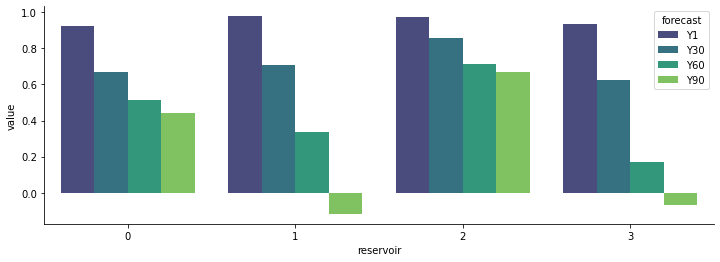

In [12]:
f, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x="reservoir", y="value", hue="forecast", data=d, palette="viridis")
sns.despine()

In [13]:
lookup = {0: 'harangi', 1: 'hemavathy', 2: 'kabini', 3: 'krisharaja_sagar'}

# What do the raw plots look like?

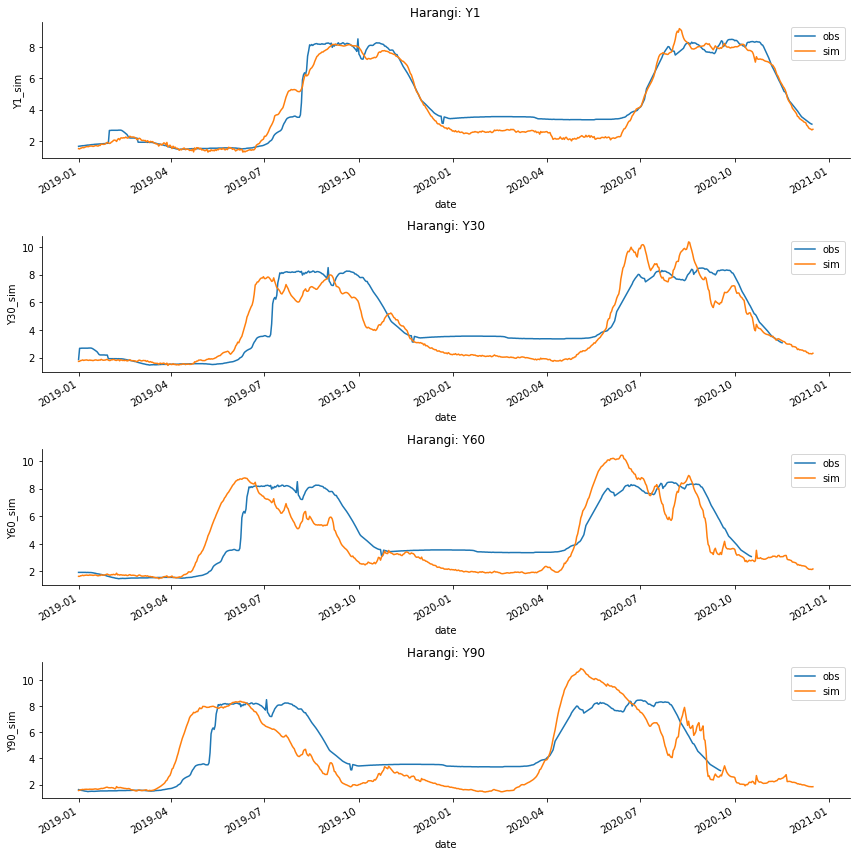

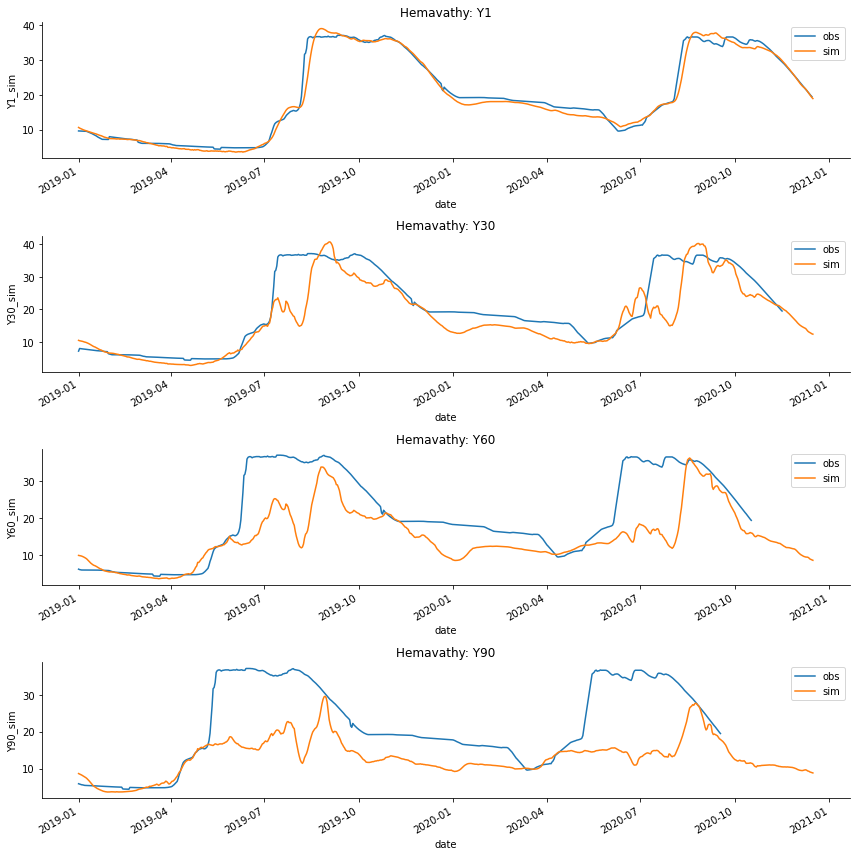

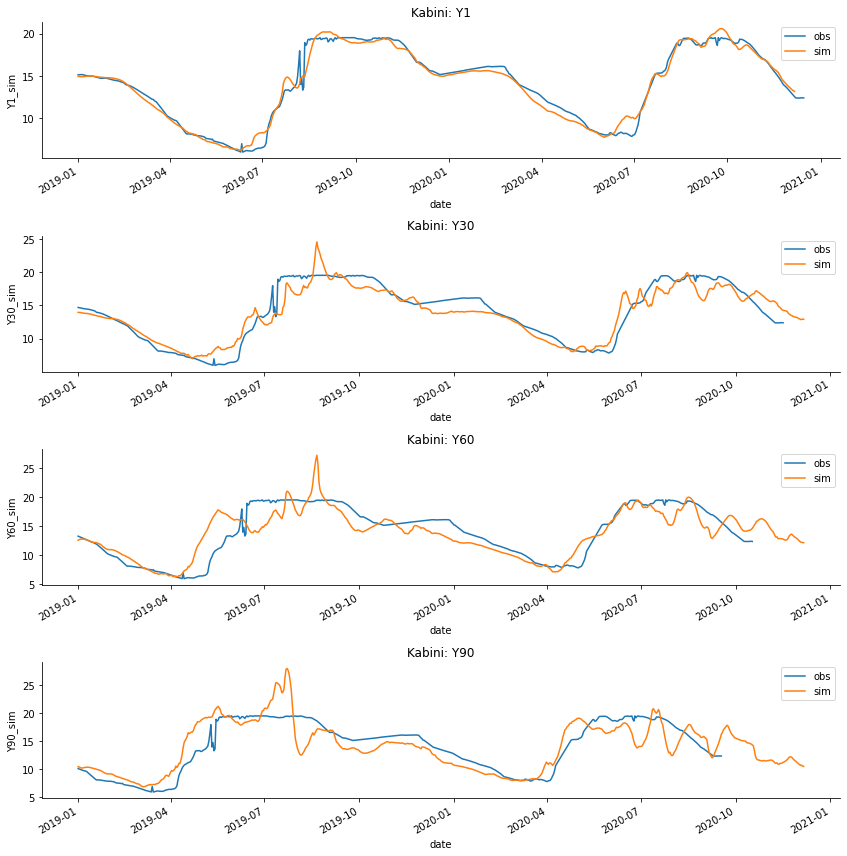

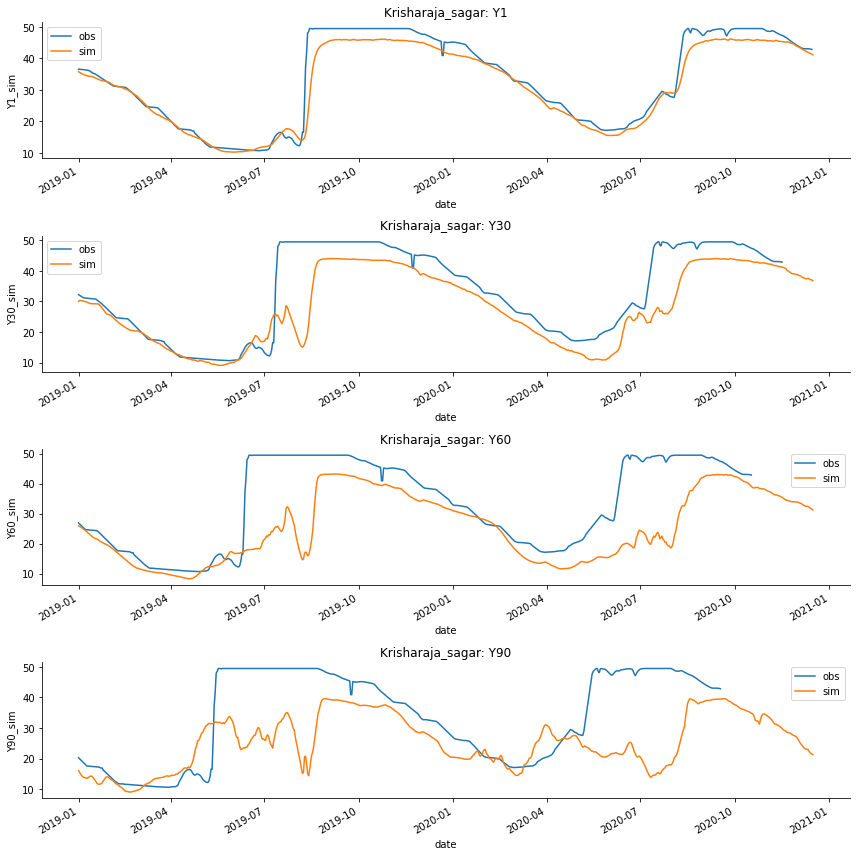

In [14]:
# fcast_vars = [v.split("_sim")[0] for v in all_preds.data_vars if "sim" in v]
fvar = targets[0]

for sid in all_preds.station_id.values:
    p = all_preds.sel(station_id=sid)
    f, axs = plt.subplots(4, 1, figsize=(12, 3*4))
    for ix, fvar in enumerate(targets):
        ax = axs[ix]
        title = lookup[int(p.station_id.values)]
        p[f"{fvar}_obs"].plot(label="obs", ax=ax)
        p[f"{fvar}_sim"].plot(label="sim", ax=ax)
        ax.set_title(f"{title.capitalize()}: {fvar}")
        ax.legend()
        sns.despine()
    plt.tight_layout()